In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.linalg import norm
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpStatus, LpVariable, LpAffineExpression
import requests

# Data Science Challenge
Candidata: Laura Camila Ocampo

## Introducción al problema

### Idea general

Se quiere diseñar un proceso de abastecimiento mensual de unidades de una portafilio de productos, de forma que se maximicen las ganancias después de costos operativos, esto teniendo en cuenta que no poder satisfacer la demanda implica una costo de oportunidad muy alto dependiendo del comportamiento aleatorio de la demanda de cada bien. 
Con este fin proponemos, en términos superficiales, el siguiente modelo

1. ***Optimización individual:*** 
Para cada ítem calcular el nivel mínimo de inventario que debe tener utilizando una estimación de las ventas diarias esperadas $\mu$. 
2. **Optimización conjunta**
Teniendo los precios $p_i$, los niveles actuales de inventario disponible $s_i$ y los niveles mìnimos de inventario $\sigma_i$ de cada producto $i$, resolvemos el siguiente Programa Lineal con restricciones enteras mixtas(MILP).

$$ (\mathcal{I})  \begin{cases} \; \begin{array} &\operatorname{max}_{a\in \mathbb{R}^P} & \sum^n_{i=1} \mu_i p_i( a_i+s_i) \\ \text{s.a.} & \sum_{i=1}^P (s_i+a_i)\leq M_{TOTAL}  \\&a_i\in \{\sigma_i,\sigma_i+1,\sigma_i+2\cdots\} \end{array}   \end{cases}$$

lo cual nos va a indicar cuánta cantidad $a_i$ comprar del ítem $i$.

### Detalles de optimización individual

En la optimización individual queremos generar una política óptima de inventario para un solo bien. Estas políticas siempre son de la siguiente forma

$$\pi(\text{inventario })=\begin{cases} \text{Compre } \Sigma-\text{inventario }  \text{unidades}  & \text{inventario }\leq \sigma \\
\text{No compre nada} & \text{inventario }> \sigma  \end{cases}$$

es decir, esas políticas óptimas están parametrizadas por unos niveles máximos y mínimos de inventario. Tenemos interés en encontrar ese nivel de inventario mínimo óptimo para cada item.

Para esto modelaremos el proceso de inventarios como un Proceso de Decisión de Markov y con este fin estableceremos la siguiente notación: 

Asumimos que ningún ítem puede superar las $M$ unidades almacenadas en bodega.

Al inicio de cada etapa de tiempo (en nuestro caso asumiremos un día) $t\in\{1,2,\cdots\}$ se tiene un nivel de inventario aleatoreo 
$$S_t\in S:=\{0,\cdots,M\}$$
ante el cual debemos tomar la decisión de cuántas unidades  $$a_t\in\mathcal{A}(S_t):= \{0,1,\cdots,M-S_t\}$$ de inventario adquirir.

Como queremos satisfacer la demanda $D_t$ de este bien en el día $t$, podemos asumir que las unidades en inventario al siguiente mes están dadas por 
$$S_{t+1}=\max\{0,S_t+a_t-D_t\}.$$
Para hablar de ganancias y costos operativos, sean $K$ los costos fijos y $c(u)$ los costos variables de adquirir $u$ unidades del bien. De esta forma, el valor del costo de ordenar $u$ unidades de producto va a estar dado por 
$$O(u):=\begin{cases}K+c(u)&u>0\\0&u=0\end{cases}.$$
Vamos a asumir que los únicos costos además de los de adquisición, son los de bodegaje (costo de mantener $u$ unidades de inventario en bodega) dados por $h(u)$. Finalmente, las ganancias por vender $j$ unidades son $f(j)$ si $j\leq S_t+a_t$ y $f\left(S_t+a_t\right) $ de lo contrario.


Así pues las ganacias después de costos operativos van a estar dadas por 
$$r_t(s,a,S_{t+1})=f(s+a-S_{t+1})-O(a)-h(s+a)$$
que implica que 
\begin{align}r_t(s,a):= &E[r_t(s,a,S_{t+1})]=E[f(s+a-S_{t+1})]-O(a)-h(s+a)\\
                                            \quad \\
                &=\sum_{k=0}^{\infty}f(k)\Pr(s+a+S_{t+1}=k)-O(a)-h(s+a)\\
                \quad \\
                &=f(s+a)\Pr\left(S_{t+1}=0\right)+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a)\\
                &=f(s+a)\sum_{j\geq s+a}\Pr\left(D_t=j\right)+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a)\\
                &=f(s+a)\Pr(D_t\geq s+a) + \sum_{j<s+a}f(j)\Pr\left(D_t=j\right)-O(a)-h(s+a) \\
                &=\underbrace{f(s+a)(1-\Pr(D_t\leq s+a-1))+\sum_{j<s+a}f(j)\Pr\left(D_t=j\right)}_{F(s+a):=} -O(a)-h(s+a)
                \end{align}

Con lo anterior ya tendríamos espacio de estados, acciones y recompensas. Para tener un proceso de decisión de Markov restaría tener solo las probabilidades de transición que van a estar dadas por
$$\Pr(j|s,a):=\begin{cases}0 & j>s+a\\  \Pr\left(D_t=s+a-j\right) &s+a\geq j>0 \\  \Pr\left(D_t\geq s+a\right) & j=0 \end{cases}$$

## Código y resultados numéricos

### Funciones básicas y variables globales necesarias

In [2]:
K=2
L=0.9
M=20
#Ganancias
def f(inventory_level,item_price):
    """Calcula ganancias por vender s unidades a un precio p"""
    return item_price*inventory_level*0.01
#Costo variable por orden
def c(inventory_level):
    """Calcula costo por vender s unidades"""
    return 2*inventory_level
#Costo de bodegaje
def h(inventory_level):
    """Costo por almacenar s unidades"""
    return inventory_level
#Costo de orden
def O(inventory_level):
    """Costo por vender s unidades más costos fijos"""
    if inventory_level==0:
        cost=0
    elif inventory_level>0:
        cost= K + c(inventory_level)
    else:
        raise Exception("Inventory level should be non-negative")
    return cost

In [3]:
#Recompensas
#Para hacer más fácil la escritura de puntos a continuación
#Voy a establecer que cuando a no es un estado admisible
#i.e. s+a>M, entonces r(s,a)=-infty

In [4]:
def r(inventory_level,inventory_adquisition,mu_item,price_item):
    """Función de recompensa del proceso de decisión de markov"""
    if inventory_level+inventory_adquisition<=M:
        ganancias_brutas=f(inventory_level+inventory_adquisition,price_item)*(
        1-poisson.cdf(inventory_level+inventory_adquisition-1,mu_item))+sum(
        f(j,price_item)*poisson.pmf(j,mu_item) for j in range(
        inventory_level+inventory_adquisition))
        reward= ganancias_brutas-O(inventory_adquisition)-h(inventory_level+inventory_adquisition)
    else:
        reward =-np.inf
    return reward

In [5]:
#Probabilidades de transición
def p(next_inventory_level,inventory_level,inventory_adquisition,mu_item):
    """Función de probabilidades de transición"""
    if (next_inventory_level>inventory_level+inventory_adquisition) or (
    inventory_level+inventory_adquisition>M) :
        transition_probability= 0
    elif inventory_level+inventory_adquisition>=next_inventory_level>0:
        transition_probability= poisson.pmf(
        inventory_level+inventory_adquisition-next_inventory_level,mu_item)
    elif next_inventory_level==0:
        transition_probability= 1-poisson.cdf(inventory_level+inventory_adquisition-1,mu_item)
    return transition_probability

### Adquisición de datos

In [6]:
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
category_list=cats.json()
for category in category_list:
    cat_id=category['id']
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}'#Arroja informacion sobre la categoria
    request = requests.get(url)
    num_registros = request.json()['paging']['total']#cuantos items hay en la categoria
    category['num_registros']=num_registros

Obtener los primeros $N$ ítems para cada categoría

In [7]:
N=50

In [8]:
lista_tablas_categorias=[]
for category in category_list:
    num_registros=min([category['num_registros'],N])
    lista_tablas_categoria=[]
    cat_id=category['id']
    for offset in range(num_registros//50):
        url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={50*offset}'
        request = requests.get(url)
        items = request.json()
        lista_filas=[
        {k:v for k,v in row.items() if not isinstance(v, dict) and not  isinstance(v, list) }
        for row in items['results']

        ]

        df=pd.DataFrame([ a for a in lista_filas if len(a.keys())==29])
        lista_tablas_categoria.append(df)

    tabla_categoria=pd.concat(lista_tablas_categoria)
    print(category['name'])
    tabla_categoria['category']= category['name']
    lista_tablas_categorias.append(tabla_categoria)
    
       

Accesorios para Vehículos
Agro
Alimentos y Bebidas
Animales y Mascotas
Antigüedades y Colecciones
Arte, Librería y Mercería
Autos, Motos y Otros
Bebés
Belleza y Cuidado Personal
Cámaras y Accesorios
Celulares y Teléfonos
Computación
Consolas y Videojuegos
Construcción
Deportes y Fitness
Electrodomésticos y Aires Ac.
Electrónica, Audio y Video
Entradas para Eventos
Herramientas
Hogar, Muebles y Jardín
Industrias y Oficinas
Inmuebles
Instrumentos Musicales
Joyas y Relojes
Juegos y Juguetes
Libros, Revistas y Comics
Música, Películas y Series
Ropa y Accesorios
Salud y Equipamiento Médico
Servicios
Souvenirs, Cotillón y Fiestas
Otras categorías


In [9]:
items_df=pd.concat(lista_tablas_categorias)

Por cada item_id único obtenemos información relativa al inventario necesaria

In [11]:
unique_items=items_df.id.unique()

inventory_details=[
    requests.get(f"https://api.mercadolibre.com/items/{item_id}".format(item_id=item_id))
    for item_id in unique_items
]

In [12]:
inventory_jsons=[item.json() for item in inventory_details ]

inventory_df=pd.DataFrame(inventory_jsons)

### Sugerencia de abastecimiento  para cada ítem (optimización individual)

En esta sección encontraremos el nivel de inventario mínimo óptimo para cada ítem $\sigma_i$ usando la estimación $\mu_i$.
$$\mu= \frac{\text{sold quantity}}{\text{tiempo transcurrido desde publicación}} $$
Para cada ítem vamos a realizar las siguientes hipótesis
* $M=20$ 
* $D_t\sim \operatorname{Poisson}(\mu)$ para algún $\mu$   que vamos a estimar con los datos de entrada.
* $c(s)= s*2$ i.e. asumimos que a pesar de que Mercado Libre no paga nada por la mercancía en bodega si incurre en algún costo (en pesos colombianos) por adquirir usuarios que publiquen en la página. 
* $h(s)=s$, 
* $K=2$, 
* $f(s)=0.1*price*s$  i.e asumimos que Mercado Libre gana 10% de cada venta que se realiza por la página

Todas estas hipótesis son sencillamente modificables en el código y sirven como un punto de partida básico para que se de a entender la dinámica de mi propuesta de solución al problema. De manera que por ingenuas o desinfomradas que parezcan las hipótesis, no afectan la calidad de la solución del reto.

#### Estimación de la media para cada ítem

In [16]:
inventory_df=inventory_df.astype({'start_time':'datetime64[ns]',
                                 'stop_time':'datetime64[ns]',
                                 'initial_quantity': 'float64',
                                 'available_quantity':'float64',

                                  })

In [17]:
inventory_df['stop_time_truncated']=np.where(inventory_df['stop_time']<=pd.to_datetime('today'),
                                             inventory_df['stop_time'],
                                             pd.to_datetime('today')
                                             )

inventory_df['elapsed_days']=(inventory_df['stop_time_truncated']-inventory_df[
'start_time']).dt.days
inventory_df['expected_daily_sales']=(inventory_df['initial_quantity']-inventory_df[
'available_quantity']) /inventory_df['elapsed_days']


Text(0, 0.5, 'plata esperada')

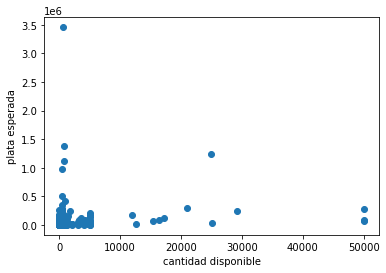

In [20]:
fig, ax= plt.subplots()
ax.scatter(x=inventory_df.available_quantity, y=inventory_df.expected_daily_sales*inventory_df.price)
ax.set_xlabel('cantidad disponible')
ax.set_ylabel('plata esperada')

#### Iteración por valor

Como modelamos el problema como un proceso de decisión markoviano, podemos implementar cualquier algoritmo disponible para encontrar políticas óptimas en este tipo de procesos.

En esta ocasión vamos a utilizar el algoritmo de Value Iteration que consiste en caracterizar la solución óptima (la política de abastecimiento óptima) como un punto fijo de determinada función, el cual se puede aproximar sencillamente iterando esa función varias veces.

A pesar de que nuestra solución aproximada podemos garantizar que es bastante cercana (más cerca que un parámetro de entrada $ɛ>0$ a la solución verdadera)

Antes vamos a hacer una justificación matemática del codigo a continuación. Necesitamos encontrar un punto fijo $v$ de 
$$ \mathcal{L}v(s):=\max_{a}\{r(s,a)+\lambda\sum_{j=0}^M p(j|s,a)v(j)\} $$

$$ \mathcal{L}v= v$$

Defina

$$ P_{sa}:=\begin{pmatrix} p(0|s,a)\\ p(1|s,a) \\ \vdots \\ p(M|s,a) \end{pmatrix} \quad \text{y} \quad r_s:=\begin{pmatrix} r(s,0)\\ r(s,1) \\ \vdots \\ r(s,M) \end{pmatrix}$$

Si $P_s\in \mathbb{R}^{(M+1)\times (M+1)}$ es la matriz cuya fila $a$ es $ P_{sa}$ entonces 
$$ \mathcal{L}v(s)= \max \left( r(s)+\lambda P_s v \right) $$
donde el máximo es tomado componente a componente. 


Finalmente, si defino $w_s:=r(s)+\lambda P_s v$ y para una matriz $X$ defino $\max X \in \mathbb{R}^{(M+1)\times 1} $ como el máximo en cada fila, obtengo que 

$$ \mathcal{L}v=\max \begin{pmatrix} w_0^T \\ \hline w_1^T \\ \vdots \\ \hline w_M^T  \end{pmatrix} $$ 


Rercuerde que todo lo anterior tiene sentido porque establecimos

$$p(j|s,a)=0 \quad \text{y} \quad r(s,a)=-\infty$$ 

para todo $a\notin \mathcal{A}(s)$ i.e. siempre que $ s+a>M$. 


$$ $$

#### Ejemplo con un ítem fijo

La ventaja de modelar el paso de optimización individual como un Proceso de Decisión de Markov es que las políticas óptimas de abastecimiento son de la forma


$$\pi(s)=\begin{cases} \Sigma-s & s\leq\sigma \\ 0 & s>\sigma \end{cases}$$

Es decir,  $\Sigma$  y  $\sigma$  son los niveles máximo y mínimo de inventario óptimos para ese ítem. El proceso de iteración por valor nos dice cuales son

In [21]:
random_item=inventory_df[(inventory_df['expected_daily_sales']>=8)&(inventory_df[
'expected_daily_sales']<16)].sample(1)

mu,price= random_item['expected_daily_sales'].values[0],random_item['price'].values[0]
print(mu,price)

9.745785876993166 10499.0


In [22]:
# Definimos la contracción a la cual le vamos a encontrar un casi punto fijo
#L(v)=v
# Acá v es un vector en R^M
def L2(vector_rm,mu_item,price_item):
    """Función a la cual se le encuentra un punto fijo en el algoritmo
    value iteration"""
    vector_rm=vector_rm.reshape((M+1,1))
    #Creamos una lista para almacenar los w_s
    valores_maximos=[]
    for inventory_level in range(M+1):
        r_s=np.array([r(inventory_level,a,mu_item,price_item) for a in range(M+1)]).reshape((M+1,1))
        p_s=np.array([[p(j,inventory_level,a,mu_item) for j in  range(M+1)]  for a in range(M+1)]).reshape((M+1,M+1))
        if sum(np.matmul(p_s,np.ones((M+1,1))))<M-inventory_level:
            print(sum(np.matmul(p_s,np.ones((M+1,1)))==1), 'Todo está mal')
        valores_maximos.append(float(max(r_s+L*np.matmul(p_s,vector_rm))))

    return np.array(valores_maximos).reshape((M+1,1))

In [23]:
#Elegimos un varEps pequeño
VAR_EPS=10**-2
#Se inicializa v0 en 0
v_VI=np.zeros((M+1,1))
#Iteramos hasta satisfacer el criterio de parada
CONT=0
vectoresVI=[]
v_VINext=L2(v_VI,mu,price)
#Condición que garantiza que estamos a epsilon de la política óptima real
while norm(v_VI-v_VINext,ord=np.inf)>=VAR_EPS*(1-L)/(2*L):
    vectoresVI.append(v_VI)
    CONT+=1
    if CONT%50==0:
        print(CONT,norm(v_VI-v_VINext,ord=np.inf))
    v_VI=v_VINext
    v_VINext=L2(v_VI,mu,price)

50 5.625793886672909
100 0.028994077056267997


En la siguiente gráfica vemos como con cada iteración del algoritmo, la política obtenida se acerca cada vez más a la verdadera

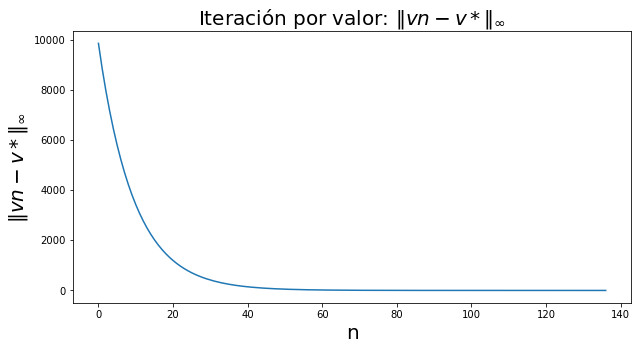

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(r'Iteración por valor: $\Vert vn-v*\Vert_\infty$',fontsize=20)
ax.set_xlabel('n',fontsize=20)
ax.set_ylabel(r'$\Vert vn-v*\Vert_\infty$',fontsize=20)
#ax.axhline(y=varEps*(1-L)/(2*L), c='red')
#ax.legend(['Criterio de parada'])
plt.plot([norm(v_VI-x,ord=np.inf) for x in vectoresVI])

Utilizando el $v$ óptimo obtenido, conseguimos la política óptima $\pi$ 

In [25]:
mu_VI=np.zeros((M+1,1))
for k in range(M+1):
    #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
    dic_valores={}
    for a in range(M-k+1):
        x=L*np.array([[p(j,k,a,mu)] for j in range(M+1)])
        valor=r(k,a,mu,price )+float(np.matmul(x.T,v_VI))
        dic_valores[a]=valor
    #Obtener la llave (el a) del diccionario donde el valor fue máximo y
    # almacenarlo en el vector mu2 en la entrada s
    mu_VI[k][0]=float(max(dic_valores, key=dic_valores.get))

In [26]:
sigma_1,sigma_2=max(np.nonzero(mu_VI)[0]),float(max(mu_VI))
print('Sigma mayúscula es ', sigma_2, ' y sigma minúscula es ', sigma_1)

Sigma mayúscula es  17.0  y sigma minúscula es  15


In [27]:
def optimal_inventory_policy(inventory_level,sigma_uno,sigma_dos):
    """Cantidad optima de inventario a adquirir"""
    if inventory_level>sigma_uno:
        optimal_inventory= 0
    else:
        optimal_inventory= sigma_dos-inventory_level
    return optimal_inventory


In [28]:
sigma_1,sigma_2=5,13
MU=10

DIAS_SIMULACION=10


inventario_inicio_dia=[sigma_2]
demanda_inicial=np.random.poisson(MU)
demandas=[demanda_inicial]
inventario_fin_dia=[sigma_2-demanda_inicial]
T=0
while T<DIAS_SIMULACION-1:
    inventario_fin_dia_anterior=inventario_fin_dia[-1]
    inventario_inicio_hoy=inventario_fin_dia_anterior+optimal_inventory_policy(
    inventario_fin_dia_anterior,sigma_1,sigma_2)
    inventario_inicio_dia.append(inventario_inicio_hoy)
    demanda_hoy=np.random.poisson(MU)
    demandas.append(demanda_hoy)
    inventario_fin_dia.append(inventario_inicio_hoy-demanda_hoy)
    T+=1

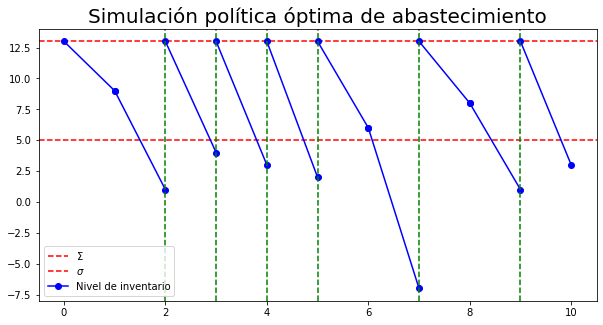

In [29]:
#x_labels=['inventario_inicio_dia_{}'.format(i+1) for i in range(dias_simulacion)]
fig,ax=plt.subplots(figsize=(10,5))
ax.axhline(y=sigma_2,ls='--',color='red')
ax.axhline(y=sigma_1,ls='--',color='red')
ax.set_title('Simulación política óptima de abastecimiento',fontsize=20)
#ax.set_xlabel(x_labels)
for dia in range(DIAS_SIMULACION):
    ax.plot(
        [dia,dia+1],
        [inventario_inicio_dia[dia],
          inventario_fin_dia[dia]],
        marker='o',color='blue')
    if (inventario_inicio_dia[dia]==sigma_2) and dia>0:
        ax.axvline(x=dia,

                   ls='--',
                   color='green')

ax.legend([r'$\Sigma$' , r'$\sigma$', 'Nivel de inventario'])

#### Calculo para todos los ítems

In [30]:
def calcular_sigmas(mu_item,price_item):
    """calcular en nivel maximo y minimo de inventario optimo"""
    mu_vi=np.zeros((M+1,1))
    for s in range(M+1):
      #Diccionario en donde almacenamos {a: r(s,a)+ lambda sum p(j|s,a)v(j)}
        valores={}
        for a in range(M-s+1):
            x=L*np.array([[p(j,s,a,mu_item)] for j in range(M+1)])
            valor=r(s,a,mu_item,price_item )+float(np.matmul(x.T,v_VI))
            valores[a]=valor
      #Obtener la llave (el a) del diccionario donde el valor fue máximo y
      # almacenarlo en el vector mu2 en la entrada s
            mu_vi[s][0]=float(max(valores, key=valores.get))
    try:
        sigma_1,sigma_2=max(np.nonzero(mu_vi)[0]),float(max(mu_vi))
    except ValueError:
        sigma_1,sigma_2=mu_item-2,mu_item
    return sigma_1,sigma_2

In [31]:
sigma_1_list=[]
sigma_2_list=[]
for i,row in inventory_df.iterrows():
    mu,price=row['expected_daily_sales'],row['price']
    if 2<=mu<=M:
        sigma_1_item,sigma_2_item=calcular_sigmas(mu,price)
        sigma_1_list.append(sigma_1_item)
        sigma_2_list.append(sigma_2_item)

    elif M>mu:
        sigma_1_list.append(mu-2)
        sigma_2_list.append(mu)
    else:
        sigma_1_list.append(0)
        sigma_2_list.append(1)

In [32]:
inventory_df['sigma_2']=sigma_2_list
inventory_df['sigma_1']=sigma_1_list

## Sugerencia de abastecimiento para la canasta entera (Optimización conjunta)

En esta sección usamos el output $\sigma_i$ de la optimización pasada para resolver

$$ (\mathcal{I})  \begin{cases} \; \begin{array} &\operatorname{max}_{a\in \mathbb{R}^P} & \sum^n_{i=1} \mu_i p_i( a_i+s_i) \\ \text{s.a.} & \sum_{i=1}^P (s_i+a_i)\leq M_{TOTAL}  \\&a_i\in \{\sigma_i,\sigma_i+1,\sigma_i+2\cdots\} \end{array}   \end{cases}$$

Esto lo haremos usando la librería PULP que sirve  para resolver una gran variedad de problemas de optimización con restricciones enteras.

In [33]:
M_TOTAL=(M+800)*inventory_df.id.nunique()

In [34]:
def MILP_inventario(p_vector,mu_vector,s_vector,sigma_1_vector):
    """Recibe el vector de precios p, el vector de medias mu, el vector de estados
    actuales de inventarios s y el vector de inventarios máximos sigma_2_vect.
      Retorna el vector de cantidad de inventarios a abastecer: a
    """
    num_items=mu_vect.shape[0]

    # Creamos el problema
    lp_problem = LpProblem(name='I_de_inventario_jeje',sense=LpMaximize)

    #Creamos los diccionarios de variables continuas en [0,1] correspondientes a las c_j y y_i
    a_var=LpVariable.dicts('a',indexs=range(num_items),lowBound=0,cat='Integer')

    # Creamos la restricción de capacidad
    print(M_TOTAL)
    lp_problem+=(LpAffineExpression([(a_var[i],1) for i in a_var.keys()])<=M_TOTAL-s_vector.sum(),
     'restriccion_capacidad_total')

    #Creamos la restriccion de rango de inventario
    for j in a_var.keys():
        lp_problem+=(a_var[j]>=sigma_1_vector[j]-s_vector[j], f'restriccion_rango_{j}'.format(j=j))


    #Ponemos una función objetivo


    lp_problem+= LpAffineExpression([(a_var[i],p_vect[i]*mu_vector[i]) for i in a_var.keys() ])+ (
    p_vector*mu_vector*s_vector).sum()

    #Resolvemos el problema
    status=lp_problem.solve()
    print(LpStatus[status])
    return np.array([a_var[i].value() for i in a_var.keys()])

In [35]:
inventory_df_not_na= inventory_df[ (inventory_df['price'].notna()) &
                                          (inventory_df['expected_daily_sales'].notna()) &
                                         (inventory_df['available_quantity'].notna()) &
                                         (inventory_df['sigma_1'].notna())
                                         ]

In [36]:
p_vect,mu_vect,s_vect,sigma_1_vect=inventory_df_not_na['price'].values,inventory_df_not_na[
'expected_daily_sales'].values,inventory_df_not_na[
'available_quantity'].values,inventory_df_not_na['sigma_1'].values

In [37]:
optimal_inventory_adquisition=MILP_inventario(p_vect,mu_vect,s_vect,sigma_1_vect)

559240
Optimal


C:\Users\57301\AppData\Local\Temp/ipykernel_22964/1508691483.py:12: DeprecationWarning: 'indexs' is deprecated; use 'indices'.
  a_var=LpVariable.dicts('a',indexs=range(num_items),lowBound=0,cat='Integer')


In [38]:
inventory_df_not_na['sugerencia_abastecimiento']=optimal_inventory_adquisition
inventory_df_not_na['expected_daily_income']=inventory_df_not_na['expected_daily_sales']*inventory_df_not_na['price']

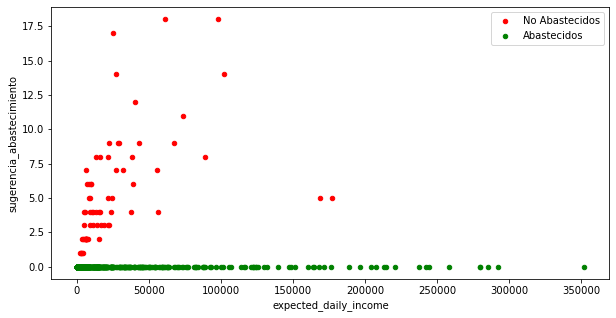

In [40]:
fig,ax=plt.subplots(figsize=(10,5))

inventory_df_not_na[(inventory_df_not_na['expected_daily_income']<0.4*10**6)&
                      (inventory_df_not_na['sigma_1']>=inventory_df_not_na['available_quantity'])
                    ].plot(x='expected_daily_income',
                         y='sugerencia_abastecimiento',
                         color='red',
                         ax=ax,
                         kind='scatter')

inventory_df_not_na[(inventory_df_not_na['expected_daily_income']<0.4*10**6)&
                      (inventory_df_not_na['sigma_1']<inventory_df_not_na['available_quantity'])
                    ].plot(
                         x='expected_daily_income',
                         y='sugerencia_abastecimiento',
                         color='green',
                         ax=ax,
                         kind='scatter'
                         )

ax.legend(['No Abastecidos','Abastecidos'])